<h1>Neural Network</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_boston, make_circles, make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


from IPython.display import HTML

<h3>Let's define some loss functions we will optimize (with treir derivatives)</h3>

In [2]:
def mse(y_true, y_pred):
    '''
    Compute mean squared error, y_pred - vector of size n_objects
    '''
    return np.mean(np.power(y_true - y_pred, 2))

def mse_derivative(y_true, y_pred):
    '''
    Compute derivative of MSE
    '''
    return -2 * (y_true - y_pred) / len(y_true)

def log_loss(y_true, a_pred):
    '''
    Compute log loss, a_pred - vector of size n_objects
    '''
    return np.mean(-y_true * np.log(a_pred) - (1 - y_true) * np.log(1 - a_pred))

def log_loss_derivative(y_true, a_pred):
    '''
    Compute detivative of log loss
    '''
    return (-y_true / a_pred + (1 - y_true) / (1 - a_pred)) / len(y_true)

def cross_entropy_loss(y_true, a_pred):
    '''
    Compute cross-entropy loss, a_pred - matrix with shape [n_objects; n_classes]
    '''
    loss = 0
    for i, j in enumerate(y_true):
        loss += -np.log(a_pred[i][j[0]])
    return loss

def cross_entropy_loss_derivative(y_true, a_pred):
    '''
    Compute derivative for cross-entropy loss
    '''
    loss = []
    for i, j in enumerate(y_true):
        loss.append(-1 / a_pred[i][j[0]])
    return np.array(loss).reshape(-1, 1)

<h3>Define some activation functions as well</h3>

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

def tanh(z):
    return np.tanh(z);

def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2;

def RElU(z):
    return np.maximum(0, z)

def RElU_derivative(z):
    return (z > 0).astype(int)

def softmax(z):
    '''
    Softmax function, z - matrix with shape [n_objects; n_classes]
    '''
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

def softmax_grad(z, y_true):
    '''
    Softmax derivative for cross-entropy loss! y_true - vector of true classes
    with shape [n_objects], classes from 0 to n_classes-1
    '''
    s = softmax(z)
    grad = np.zeros(shape=s.shape)
    for obj, target in enumerate(y_true):
        for z in range(len(s[obj])):
            if target == z:
                grad[obj][z] = s[obj][z] * (1 - s[obj][z])
            else:
                grad[obj][z] = -s[obj][target] * s[obj][z]
    return grad

<p>Let's define some typical NN layers</p>

In [4]:
class Linear:
    '''
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    '''
    def __init__(self, n_input, n_output):
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(n_input, n_output)) # He initialization
        self.b = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(1, n_output))
        
    def forward(self, x):
        self.input = x
        return x.dot(self.w) + self.b
    
    def backward(self, output_error, learning_rate):
        '''
        Backpropagation
        '''
        w_grad = self.input.T.dot(output_error) # weights gradient
        b_grad = np.ones((1, len(output_error))).dot(output_error) # bias gradient
        input_error = output_error.dot(self.w.T) # error of the input is used as the output_error of the previous layer
        
        #update weights
        self.w -= learning_rate * w_grad
        self.b -= learning_rate * b_grad
        return input_error # return the error for the previous layer
    
    def __repr__(self):
        return f'Linear layer, input size:{self.n_input}, output size:{self.n_output}'
    
class Activation:
    '''
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    '''
    def __init__(self, activation_function, activation_derivative):
        self.activation = activation_function
        self.derivative = activation_derivative
        
    def forward(self, x):
        self.input = x
        return self.activation(x)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.derivative(self.input)
    
    def __repr__(self):
        return f'Activation layer, activation function:{self.activation}'
    
class SoftMaxLayer:
    '''
    Class for softmax layer, it needs y_true for initialization, all the rest are the same as "Activation" class
    '''
    def __init__(self, activation_function, activation_derivative, y):
        self.activation = softmax
        self.derivative = softmax_grad
        self.y_true = y
        
    def forward(self, x):
        self.input = x
        return self.activation(x)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.derivative(self.input, self.y_true)   
    
    def __repr__(self):
        return f'SoftMax layer'

In [5]:
class NeuralNetwork:
    '''
    NeuralNetwork class is used to build the Neural Network and train it
    Methods:
    use(loss, loss_derivative) - set the loss function and it's derivative
    add_layer(layer) - constructor of the NN, add one of the layers described above
    predict(x) - forward pass through the network
    fit(x, y, learning_rate, n_epochs, x_val, y_val) - fit the network
    '''
    def __init__(self):
        self.layers = []
        
    def use(self, loss, loss_derivative):
        self.loss = loss
        self.loss_derivative = loss_derivative
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def predict(self, x):
        prediction = x
        for layer in self.layers:
            prediction = layer.forward(prediction)
        return prediction
    
    def fit(self, x, y, learning_rate, n_epochs, x_val=None, y_val=None):
        
        loss_print_epoch = n_epochs / 10 # print the loss 10 times
        
        for _ in range(n_epochs):
            preds = self.predict(x) # predict the output
            err = self.loss(y, preds) # calculate the loss, only for printing
            output_error = self.loss_derivative(y, preds) # calculate the error to start backpropagation
            
            for layer in reversed(self.layers):
                output_error = layer.backward(output_error, learning_rate) # backward pass
                
            if x_val is not None and y_val is not None: # print the loss for the validation set
                err_val = self.loss(y_val, self.predict(x_val))
                if _ % loss_print_epoch == 0:
                    print('*' * 30)
                    print(f'Epoch {_}  train_loss:{err}, val_loss:{err_val}')
            else:
                if _ % loss_print_epoch == 0:
                    print('*' * 30)
                    print(f'Epoch {_}  train_loss:{err}')
            
            
        return self
    
    def __repr__(self):
        return f'NeuralNetwork class, layers:\n{self.layers}'

<p>Let's solve the XOR problem first</p>

In [6]:
x_XOR = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_XOR = np.array([[0], [1], [1], [0]])

In [7]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [8]:
nn.fit(x_XOR, y_XOR, 0.1, 1000)

******************************
Epoch 0  train_loss:0.6930024053152963
******************************
Epoch 100  train_loss:0.6686401733989339
******************************
Epoch 200  train_loss:0.6223050428077765
******************************
Epoch 300  train_loss:0.49297790103268013
******************************
Epoch 400  train_loss:0.3079909331803791
******************************
Epoch 500  train_loss:0.18551530758267815
******************************
Epoch 600  train_loss:0.12205263493072654
******************************
Epoch 700  train_loss:0.0876032913271639
******************************
Epoch 800  train_loss:0.06706121790813196
******************************
Epoch 900  train_loss:0.05376625008436846


NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001F5D4CD8EE8>]

In [9]:
nn.predict(x_XOR) 

array([[0.03819667],
       [0.95371741],
       [0.94229109],
       [0.03206782]])

<p>Looks good, let's try some different tasks</p>

In [10]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = np.round(clf.predict(X_new)).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][(y==0).reshape(-1)], X[:, 1][(y==0).reshape(-1)], "yo")
        plt.plot(X[:, 0][(y==1).reshape(-1)], X[:, 1][(y==1).reshape(-1)], "bs")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [11]:
data = load_iris()
x = data['data'][data['target'] != 2][:, 2:4]
y = data['target'][data['target'] != 2].reshape(-1, 1)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [13]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [14]:
nn.fit(x_train, y_train, 0.03, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:0.6519497700162773, val_loss:0.5418673784475684
******************************
Epoch 1000  train_loss:0.031143578267697616, val_loss:0.029219948122524226
******************************
Epoch 2000  train_loss:0.013343516237737496, val_loss:0.012426307674385606
******************************
Epoch 3000  train_loss:0.008282079246398842, val_loss:0.0076962979005205
******************************
Epoch 4000  train_loss:0.005950293735050477, val_loss:0.0055249178555882746
******************************
Epoch 5000  train_loss:0.004622159392025615, val_loss:0.00429037886864711
******************************
Epoch 6000  train_loss:0.003768773086355227, val_loss:0.0034979645267985402
******************************
Epoch 7000  train_loss:0.0031759744424229887, val_loss:0.0029478795457064002
******************************
Epoch 8000  train_loss:0.002741078267360404, val_loss:0.002544489659325882
******************************
Epoch 9000  train_los

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001F5D4CD8EE8>]

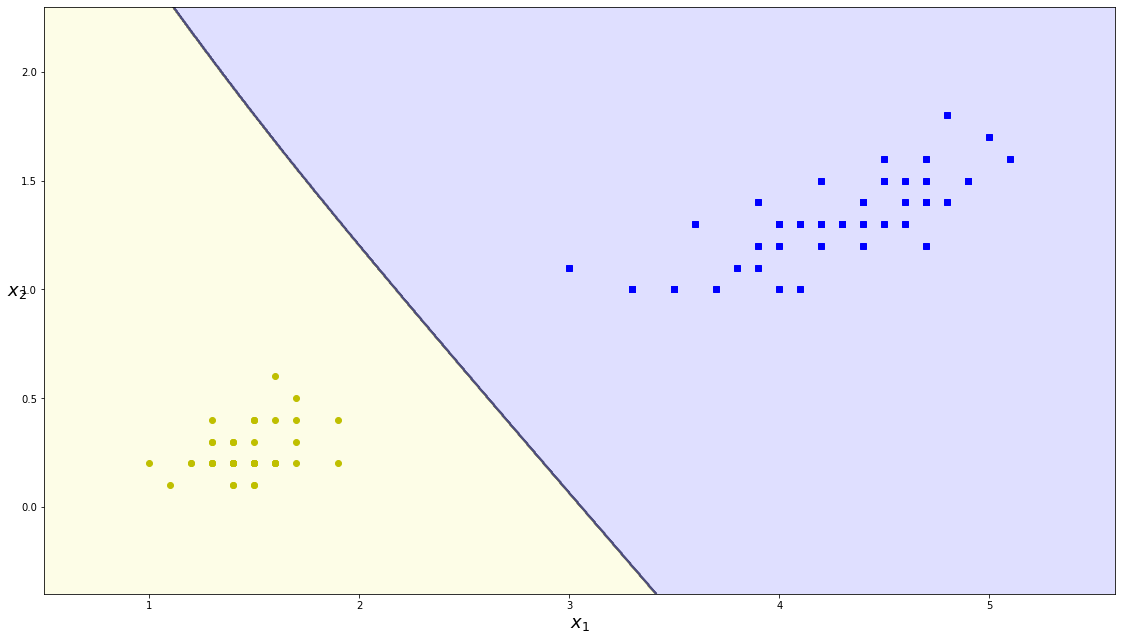

In [15]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [16]:
x, y = make_circles(n_samples=1000, noise=0.1, factor=0.5)
y = y.reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [17]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [18]:
nn.fit(x_train, y_train, 0.03, 20000, x_val, y_val)

******************************
Epoch 0  train_loss:0.9670008386128801, val_loss:1.0671163921804319
******************************
Epoch 2000  train_loss:0.6440914796799533, val_loss:0.6538819165324222
******************************
Epoch 4000  train_loss:0.5453808824268428, val_loss:0.583903565995499
******************************
Epoch 6000  train_loss:0.49223580309912013, val_loss:0.5557447618835774
******************************
Epoch 8000  train_loss:0.37215689557542836, val_loss:0.4052914337638395
******************************
Epoch 10000  train_loss:0.20167988391737893, val_loss:0.19115959421620948
******************************
Epoch 12000  train_loss:0.15978090337652961, val_loss:0.14361112720391436
******************************
Epoch 14000  train_loss:0.13946001237373673, val_loss:0.12109288283122913
******************************
Epoch 16000  train_loss:0.12635497685627922, val_loss:0.10728205830293121
******************************
Epoch 18000  train_loss:0.116491743222471

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001F5D4CD8EE8>]

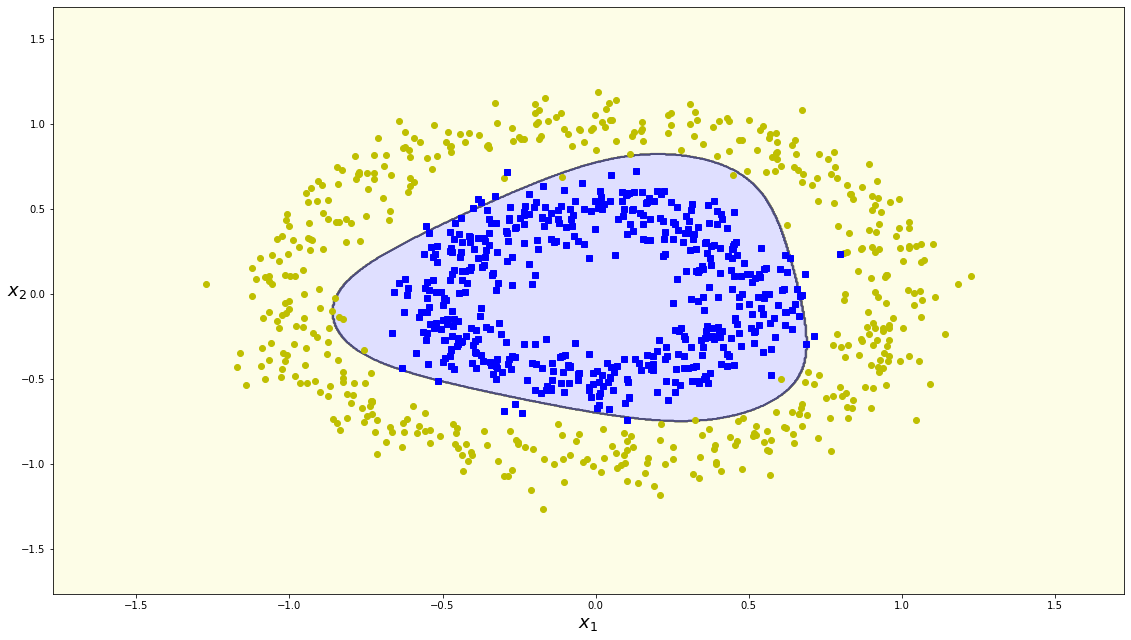

In [19]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [20]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, shift=0.1)
y = y.reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [21]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [22]:
nn.fit(x_train, y_train, 0.03, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:0.8711246787174505, val_loss:0.8409724592353641
******************************
Epoch 1000  train_loss:0.07578632095102028, val_loss:0.1010041808958997
******************************
Epoch 2000  train_loss:0.06732381840421031, val_loss:0.09719094649484415
******************************
Epoch 3000  train_loss:0.06548286096075809, val_loss:0.09763184039787906
******************************
Epoch 4000  train_loss:0.06479705630669452, val_loss:0.09831367126764892
******************************
Epoch 5000  train_loss:0.06442190978371694, val_loss:0.09881541845789543
******************************
Epoch 6000  train_loss:0.06411767901605583, val_loss:0.09907464316222399
******************************
Epoch 7000  train_loss:0.06375690334212311, val_loss:0.09904921487518972
******************************
Epoch 8000  train_loss:0.06320439780313739, val_loss:0.09869913275518084
******************************
Epoch 9000  train_loss:0.06243113415417

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001F5D4CD8EE8>]

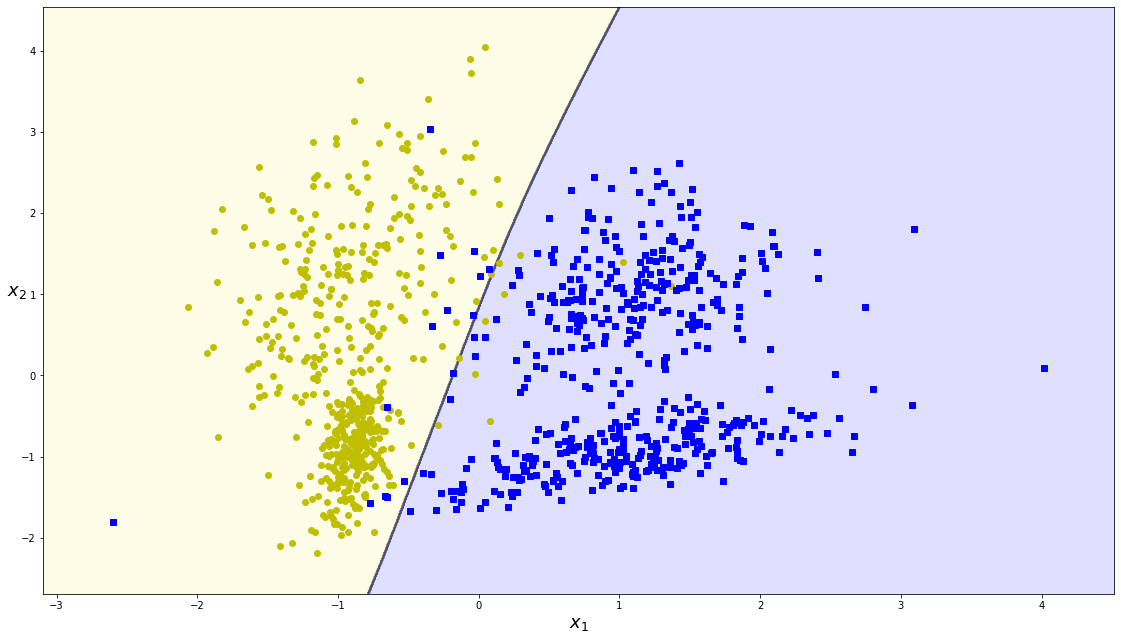

In [23]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

<p>Let's try some multiclass tasks with softmax!</p>

In [24]:
def plot_decision_boundary_for_3_classes(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = np.argmax(clf.predict(X_new), axis=1).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][(y==0).reshape(-1)], X[:, 1][(y==0).reshape(-1)], "yo")
        plt.plot(X[:, 0][(y==1).reshape(-1)], X[:, 1][(y==1).reshape(-1)], "bs")
        plt.plot(X[:, 0][(y==2).reshape(-1)], X[:, 1][(y==2).reshape(-1)], "g^")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    
def plot_decision_boundary_for_4_classes(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = np.argmax(clf.predict(X_new), axis=1).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0', '#8B0000'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50', '#8B0000'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][(y==0).reshape(-1)], X[:, 1][(y==0).reshape(-1)], "yo")
        plt.plot(X[:, 0][(y==1).reshape(-1)], X[:, 1][(y==1).reshape(-1)], "bs")
        plt.plot(X[:, 0][(y==2).reshape(-1)], X[:, 1][(y==2).reshape(-1)], "g^")
        plt.plot(X[:, 0][(y==3).reshape(-1)], X[:, 1][(y==3).reshape(-1)], "r*")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [25]:
data = load_iris()
x = data['data'][:, 2:4]
y = data['target'].reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [26]:
nn = NeuralNetwork()
nn.use(cross_entropy_loss, cross_entropy_loss_derivative)
nn.add_layer(Linear(2, 16))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(16, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 4))
nn.add_layer(SoftMaxLayer(softmax, softmax_grad, y_train))

In [27]:
nn.fit(x_train, y_train, 0.0003, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:148.90254713623267, val_loss:76.42415584782019
******************************
Epoch 1000  train_loss:24.685359897613214, val_loss:8.359663502456742
******************************
Epoch 2000  train_loss:12.064032602036074, val_loss:4.071568322065357
******************************
Epoch 3000  train_loss:10.708599733986036, val_loss:3.2534843028897256
******************************
Epoch 4000  train_loss:10.113324199133826, val_loss:2.8620822917360025
******************************
Epoch 5000  train_loss:9.80046752350474, val_loss:2.651150393169783
******************************
Epoch 6000  train_loss:9.612904779143108, val_loss:2.5314890505920156
******************************
Epoch 7000  train_loss:9.48635596970215, val_loss:2.4637638868165177
******************************
Epoch 8000  train_loss:9.388969742365072, val_loss:2.4231211005382947
******************************
Epoch 9000  train_loss:9.305418510845868, val_loss:2.39358749292

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:16, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:16, output size:4, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:4, output size:4, SoftMax layer]

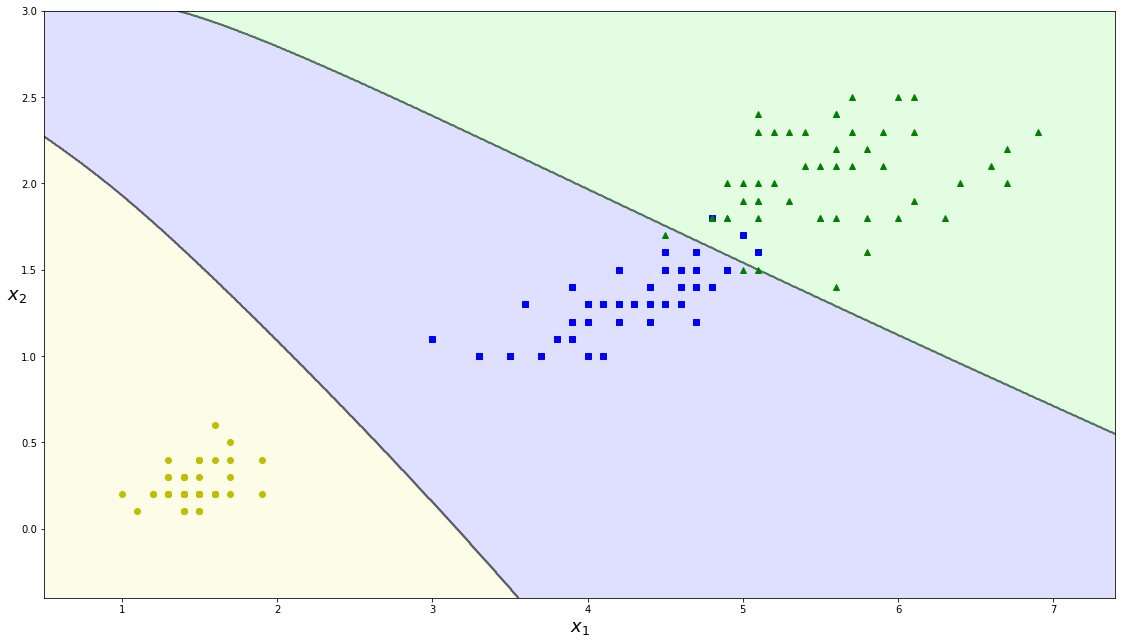

In [28]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary_for_3_classes(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [29]:
x, y = make_classification(n_samples=100, n_features=2, n_redundant=0, shift=0.5, n_classes=4, n_clusters_per_class=1)
y = y.reshape(-1, 1)

In [30]:
nn = NeuralNetwork()
nn.use(cross_entropy_loss, cross_entropy_loss_derivative)
nn.add_layer(Linear(2, 16))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(16, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 4))
nn.add_layer(SoftMaxLayer(softmax, softmax_grad, y))

In [31]:
nn.fit(x, y, 0.0003, 10000)

******************************
Epoch 0  train_loss:152.44750104917438
******************************
Epoch 1000  train_loss:35.89454098333385
******************************
Epoch 2000  train_loss:31.949448806656154
******************************
Epoch 3000  train_loss:29.768571058532245
******************************
Epoch 4000  train_loss:28.12591743869191
******************************
Epoch 5000  train_loss:26.630109597361738
******************************
Epoch 6000  train_loss:25.184895083287216
******************************
Epoch 7000  train_loss:23.817824269847637
******************************
Epoch 8000  train_loss:22.590116490861053
******************************
Epoch 9000  train_loss:21.52078114083547


NeuralNetwork class, layers:
[Linear layer, input size:2, output size:16, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:16, output size:4, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:4, output size:4, SoftMax layer]

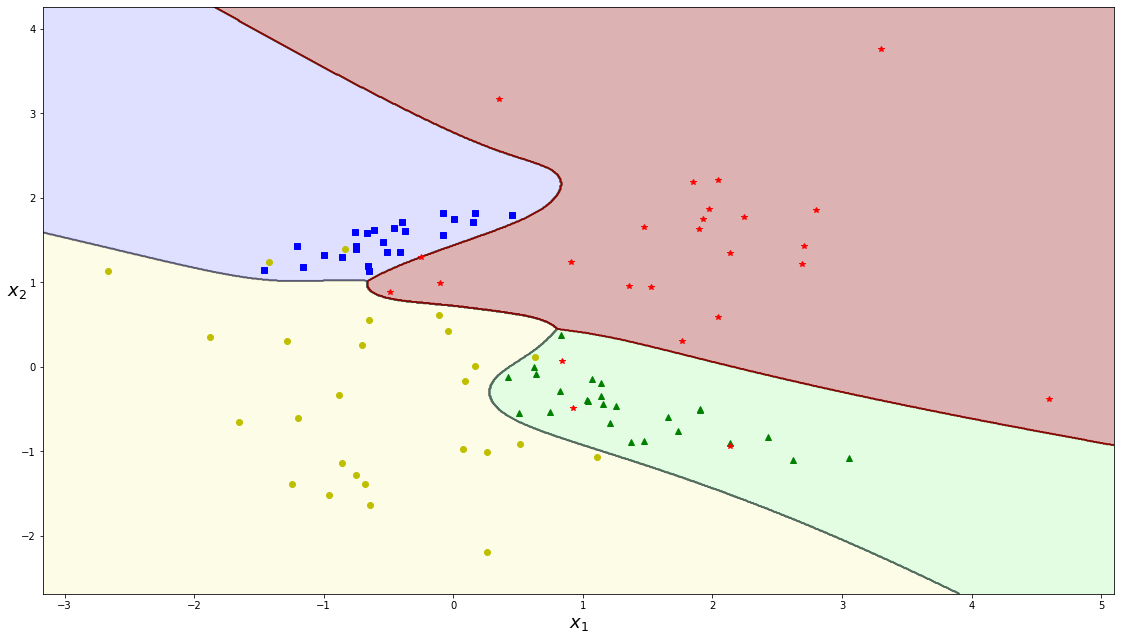

In [32]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary_for_4_classes(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

<p>Some regression</p>

In [33]:
scaler = StandardScaler()

In [34]:
data = load_boston()
x = scaler.fit_transform(data['data'])
y = data['target'].reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [35]:
nn = NeuralNetwork()
nn.use(mse, mse_derivative)
nn.add_layer(Linear(13, 6))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(6, 1))

In [36]:
nn.fit(x_train, y_train, 0.03, 1000, x_val, y_val)

******************************
Epoch 0  train_loss:657.7841681037111, val_loss:460.33680370000025
******************************
Epoch 100  train_loss:14.046123435033577, val_loss:17.85497367105218
******************************
Epoch 200  train_loss:11.147355418120048, val_loss:16.930619255187644
******************************
Epoch 300  train_loss:10.283296672289007, val_loss:15.797808216819279
******************************
Epoch 400  train_loss:9.57299279013802, val_loss:14.623790303238422
******************************
Epoch 500  train_loss:8.88495490086473, val_loss:13.728302164422065
******************************
Epoch 600  train_loss:8.662691568668853, val_loss:13.76767327762477
******************************
Epoch 700  train_loss:8.38348606667439, val_loss:13.774610250405592
******************************
Epoch 800  train_loss:8.15121415105402, val_loss:13.893482677769253
******************************
Epoch 900  train_loss:7.952416130764928, val_loss:14.014702636054505


NeuralNetwork class, layers:
[Linear layer, input size:13, output size:6, Activation layer, activation function:<function tanh at 0x000001F5D4CF6048>, Linear layer, input size:6, output size:1]

In [37]:
print(r2_score(y_val, nn.predict(x_val)))

0.812341935901562


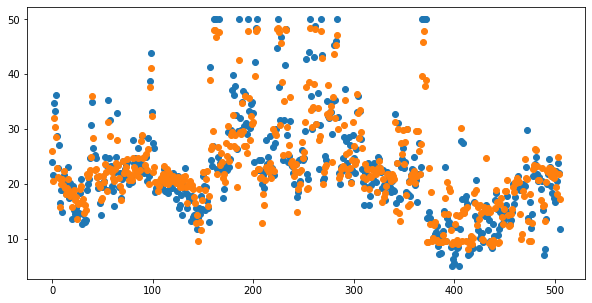

In [38]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y)
plt.scatter(range(len(y)), nn.predict(x))
plt.show()

In [39]:
with open('./style.css') as f:
    style = f.read()
HTML(style)